# Poboljšanje medicinskih slika zasnovano na algoritmima histograma

Poboljšanje medicinskih slika predstavlja ključni korak u dijagnostici i lečenju pacijenata, jer kvalitet slike direktno utiče na sposobnost lekara da pravilno tumači anatomske strukture i identifikuje potencijalne probleme. Zbog prirode medicinskih slika, koje često pate od problema kao što su niski kontrast i šum, važno je primeniti tehnike poboljšanja kako bi se obezbedila što jasnija i preciznija vizuelna informacija.

Jedan od najčešće korišćenih pristupa za poboljšanje kontrasta slike je izjednačavanje histograma (HE). Međutim, iako HE može značajno poboljšati kontrast, može takođe generisati neželjene artefakte i prekomerno pojačanje kontrasta u određenim delovima slike. Da bi se rešili ovi problemi, razvijeni su različiti napredni algoritmi zasnovani na histogramu, kao što su kumulativno izjednačavanje histograma (CHE), kvadratno dinamičko izjednačavanje histograma (QDHE), i kontrastno ograničeno adaptivno izjednačavanje histograma (CLAHE).

Ovaj projekat ima za cilj da analizira i uporedi performanse ovih algoritama na različitim medicinskim slikama. Kroz implementaciju i analizu rezultata koristeći Python, pokazujemo prednosti i nedostatke svakog od pristupa.

## Obrada Histograma Slike
Obrada histograma slike predstavlja osnovu za mnoge tehnike obrade slika u prostornom domenu. Histogram slike je grafički prikaz raspodele sivih tonova u digitalnoj slici. Prikazivanje histograma pomaže u analizi učestalosti pojavljivanja različitih sivih tonova koji su prisutni u slici.

Histogram se koristi za različite svrhe, kao što su poboljšanje kontrasta, kompresija slike i segmentacija. Algoritmi zasnovani na histogramu jednostavni su za implementaciju i mogu se efikasno primeniti na različite tipove slika. Jedan od najpoznatijih algoritama u ovoj oblasti je izjednačavanje histograma (HE), koji raspoređuje nivoe intenziteta u slici tako da budu podjednako verovatni, što rezultira slikom sa povećanim dinamičkim opsegom i poboljšanim kontrastom.

Kod medicinskih slika, histogram može pružiti korisne informacije o osvetljenju slike i njenom kontrastu. Na primer, histogram koji pokriva sve moguće vrednosti u skali sivih tonova ukazuje na to da slika ima dobar kontrast i da su detalji na slici jasno vidljivi.

In [1]:
! pip install matplotlib numpy opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

import importlib
import histogram_plots as hp

In [3]:
importlib.reload(hp)

<module 'histogram_plots' from '/home/miloje/Desktop/ni/NI_HistogramAlgorithms/histogram_plots.py'>

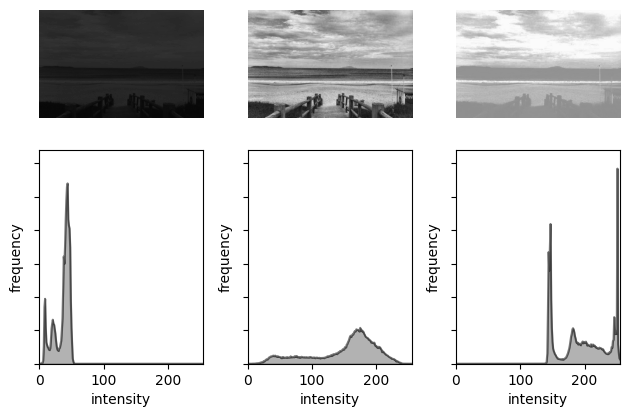

In [4]:
image_paths = [
    ('images/dark_image.jpg'),
    ('images/original_image.jpg'),
    ('images/bright_image.jpg'),
]
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]
hp.show_images_and_histograms(images,y_max=16000)

### Generisanje Histograma
Histogram digitalne slike $X$ može se predstaviti sledećom formulom:
$$ 
h_X(k) = n_k 
$$ 
gde je $n_k$ broj piksela sa intenzitetom $k$.

Posmatrajući intenzitet piksela slike kao slučajnu veličinu, definišemo *normalizovani histogram* kao empirijsku verovatnoću da piksel date slike ima određenu vrednost, što se može dobiti podelom $h(k)$ sa ukupnim brojem piksela u slici dimenzije $M \times N$:
$$ p_X(k) = \frac{n_k}{MN} $$ 

## Izjednačavanje histograma (HE)
Izjednačavanje histograma (*Histogram equalization*) transformiše vrednosti intenziteta slike tako da budu ravnomerno raspoređene po celom mogućem rasponu $[0,255]$. 

**Kumulativna distribuciona funkcija** (*CDF*) je verovatnoća da slučajna promenljiva $X$ ima vrednost *manju ili jednaku* datoj vrednosti:
$$
cdf_X(k) = \sum_{i=0}^{k}p_X(x=i).
$$

Želimo da transformišemo sliku $X$ tako da slika $Y = T(X)$ ima uniforman histogram, odnosno kumulativnu distribucionu funkciju:
$$
cdf_Y(k) = (k+1)C,
$$ 
za neku konstantu $C$.

Novu sliku dobijamo tako što piksele koji imaju intenzitet $k$ transformišemo sa:
$$
t(k) = \left \lfloor cdf_X(k)\cdot 256 \right \rfloor  .
$$

Kako se jačina intenziteta jednog piksela racuna u funkciji od njenog intenziteta na originalnoj slici, ukupan broj različitih intenziteta koji postoje na slici ostaje isti. Kako je isti broj različitih vrednosti "razvučen" sa intervala uzastopnih brojeva na veći interval, intenziteti koje neki piksel može da ima više nisu uzastopni, što vidimo na sledećem grafiku.

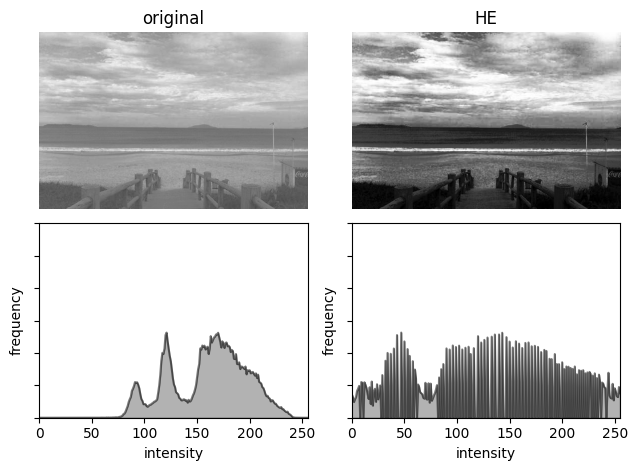

In [5]:
def cumulative_distribution_function(hist):
    total_pixels = hist.sum()    	
    norm_hist = hist / total_pixels
    cdf = np.cumsum(norm_hist)
    return cdf

def histogram_equalization(image, I_min=0, I_max=256):
    hist, _ = np.histogram(image, I_max - I_min, [I_min, I_max])
    cdf = cumulative_distribution_function(hist)
    equalized_transform = np.floor(cdf * (I_max - I_min)).astype(int)
    return equalized_transform[image]

image = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

he_image = histogram_equalization(image)

images = [image, he_image]
hp.show_images_and_histograms(images, titles = ['original', 'HE'])

## CHE ?

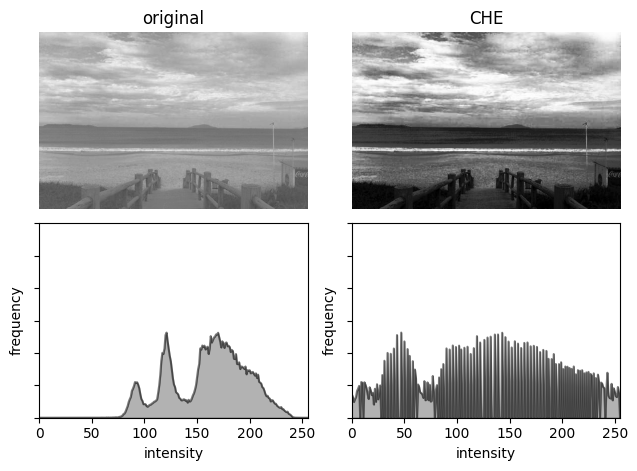

In [6]:
def cumulative_histogram_equalization(image, L=256, scale=255):
    hist, _ = np.histogram(image, L, [0, L])
    cdf = cumulative_distribution_function(hist)
    cdf_normalized = np.floor((cdf - cdf.min()) / (cdf.max() - cdf.min()) * scale).astype(int)
    return cdf_normalized[image]

che_image = cumulative_histogram_equalization(image)

images = [image, che_image]
hp.show_images_and_histograms(images, titles = ['original', 'CHE'])

## Kvadratno Dinamičko Izjednačavanje Histograma (QDHE)

Kvadratno dinamičko izjednačavanje histograma (QDHE) je napredna tehnika poboljšanja slike koja je dizajnirana da prevaziđe neke od nedostataka standardnog izjednačavanja histograma (HE). QDHE je posebno korisno za medicinske slike jer omogućava bolje očuvanje osvetljenosti slike dok istovremeno poboljšava kontrast.

QDHE metoda kombinuje nekoliko ključnih koraka kako bi postigla poboljšanje kontrasta bez prekomernog povećanja osvetljenosti, što se često dešava kod osnovnog HE i sastoji se od četiri koraka:
1. Particionisanje histograma
2. Orezivanje histograma (clipping)
3. Dodela novih raspona sivih tonova
4. Izjednačavanje histograma 


### 1. Particionisanje histograma 
Histogram slike deli se na 4 podhistograma po kvartilima.

Ovo omogućava ravnomernu distribuciju piksela u svakom od četiri podhistograma, čime se obezbeđuje kontrolisano poboljšanje kontrasta.

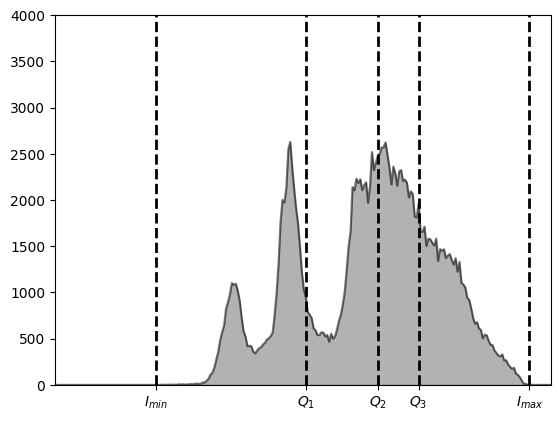

In [7]:
def partition_histogram(image):
    I_min = int(np.min(image))
    Q1 = int(np.percentile(image, 25))
    Q2 = int(np.percentile(image, 50))
    Q3 = int(np.percentile(image, 75))
    I_max = int(np.max(image))
    return [I_min, Q1, Q2, Q3, I_max]

hist, _ = np.histogram(image, 256, [0, 256])
partition_points = partition_histogram(image)

hp.show_histogram(hist=hist, xticks=partition_points)

### 2. Skraćivanje histograma (*clipping*)
Nakon particionisanja, podhistogrami se skraćuju do srednje vrednosti učestalosti intenziteta u slici. 

Ovim se ograničava maksimalan broj piksela koji ima istu vrednost, sprečavajući prekomerno pojačanje kontrasta i redukciju detalja, što pomaže u očuvanju prirodnog izgleda slike i smanjuje šum i preosvetljenje.



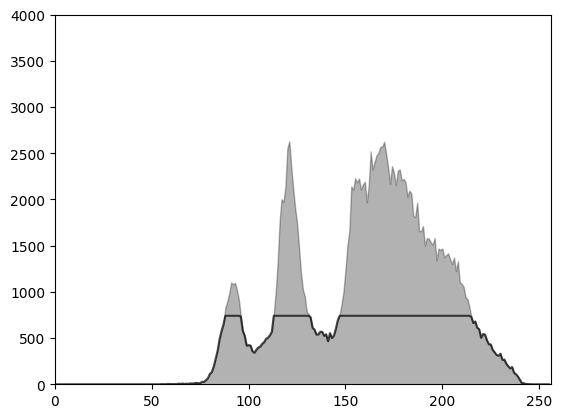

In [8]:
def clip_histogram(hist):
    threshold = hist.mean()
    clipped_hist = np.minimum(hist, threshold)
    return clipped_hist

hist, _ = np.histogram(image.flatten(), 256, [0, 256])
clipped_hist = clip_histogram(hist)

hp.show_clipped_histogram(hist=hist,clipped_hist=clipped_hist)

### 3. Dodela novog raspona sivih tonova
Svakom podhistogramu dodeljuje se novi raspon sivih tonova na osnovu njegove širine i broja piksela. Ovo omogućava ravnomerno poboljšanje kontrasta kroz celu sliku

In [9]:
def allocate_gray_levels(hist, m, L=256):
    total_pixels = hist.sum()
    
    spans = [m[i + 1] - m[i] for i in range(len(m) - 1)]
    total_span = sum(spans)
    ranges = [round((L - 1) * span / total_span) for span in spans]
    
    starts = [0] 
    ends = []

    for i in range(len(ranges)):
        if i > 0:
            starts.append(ends[i - 1])  
        end = starts[i] + ranges[i]
        ends.append(end)

    return starts, ends    

hist, _ = np.histogram(image.flatten(), 256, [0, 256])
m = partition_histogram(image)
gray_starts, gray_ends = allocate_gray_levels(hist, m)
print("original gray intervals :", *zip(m[:-1], m[1:]))
print("new gray intervals : ",*zip(gray_starts,gray_ends))

original gray intervals : (52, 129) (129, 166) (166, 187) (187, 244)
new gray intervals :  (0, 102) (102, 151) (151, 179) (179, 255)


### 4. Izjednačavanje histograma (HE) za svaki podhistogram:
Na kraju, HE se primenjuje na svaki od pod-histograma nezavisno. Ovo omogućava dinamičnije poboljšanje kontrasta u slici, jer se svaki deo opsega sive odvojeno normalizuje.


In [10]:
def qdhe(image, show_image=0, L=256):
    hist, _ = np.histogram(image, L, [0, L])
    m = partition_histogram(image)
    clipped_hist = clip_histogram(hist)
    new_starts, new_ends = allocate_gray_levels(clipped_hist, m)
    equalized_image = np.zeros_like(image)

    for i, (new_start, new_end) in enumerate(zip(new_starts, new_ends)):
        start = m[i]
        end  = m[i+1]
        mask = (image >= start) & (image < end)

        sub_hist = clipped_hist[start:end]
        cdf = cumulative_distribution_function(sub_hist)
        equalized_transform = np.floor(cdf * (new_end - new_start)).astype(int) + new_start
        equalized_image[mask] = equalized_transform[image[mask] - start]  

    if show_image == 1:
        hp.show_images_and_histograms([image,equalized_image], titles=['original', 'QDHE'], xticks = [m[:],new_starts+[new_ends[-1]]], labels = [[r"$I_{min}$", r"$Q_{1}$", r"$Q_{2}$", r"$Q_{3}$", r"$I_{max}$"],[r"$I'_{min}$",r"$Q'_{1}$", r"$Q'_{2}$", r"$Q'_{3}$",r"$I'_{max}$"]])


    return equalized_image
    

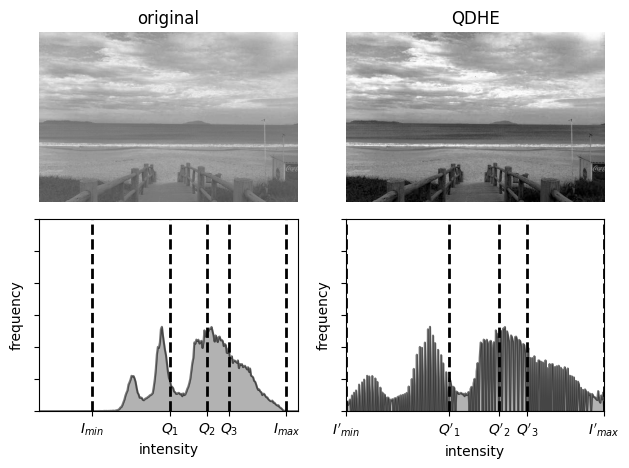

In [11]:
qdhe_image = qdhe(image,show_image=1)

### Prednosti QDHE:
- **Očuvanje osvetljenosti**: Za razliku od standardnog HE, QDHE ima sposobnost da bolje očuva ukupnu osvetljenost slike. Ovo je važno za medicinske slike gde je očuvanje prirodne osvetljenosti ključno za tačnu dijagnozu.

- **Smanjeno preosvetljenje**: Korišćenjem odsecanja, QDHE smanjuje rizik od preosvetljenja i prekomernog kontrasta u nekim delovima slike, što rezultira prirodnijim izgledom slike.

- **Bolje lokalno poboljšanje**: Deljenjem histograma u podhistograme i primenom HE na svaki podhistogram, QDHE omogućava bolje lokalno poboljšanje kontrasta, što može biti korisno za detekciju finih detalja u medicinskim slikama.

## Ograničeno adaptivno izjednačavanje histograma (*CLAHE*)

CLAHE (*Contrast-Limited Adaptive Histogram Equalization*) je tehnika koja je dizajnirana da poboljša kontrast slike, a da pritom spreči prekomerno pojačanje šuma i artefakata. 

Metoda se sastoji iz sledećih koraka:

**1. Podela slike** :
Slika se deli na nekoliko nepreklapajućih regiona približno iste veličine. Ovi regioni uključuju uglovne regione (CR), granične regione (BR) i unutrašnje regione (IR).

Za svaki region pravi se novi histogram koji se dalje procesuju zasebno.

**2. Ograničavanje histograma** :
Definiše se prag na kojem se histogram ograničava i višak piksela se redistribuira među ostalim binovima histograma. Ako je ovaj prag nizak, pojačanje kontrasta će biti suptilnije, dok će viši prag dozvoliti snažnije pojačanje kontrasta.

Redistribucija viška može ponovo dovesti do prekoračenja clip limita u nekim binovima. Ako je ovo neželjeno, postupak redistribucije može se ponoviti sve dok višak ne postane zanemarljiv.

**3. Izračunavanje kumulativne distribucije (*CDF*)** :
Nakon ograničavanja, izračunava se kumulativna distribuciona funkcija (CDF) iz ograničenih histograma. 

**4. Interpolacija** :
Za svaki piksel u slici, njegov intenzitet se prilagođava interpolacijom između CDF vrednosti četiri najbliže susedne tačke mreže, koje odgovaraju regionima izračunatim ranije. Ovo osigurava da prelaz između regiona bude gladak i da se na granicama regiona ne uvode artefakti.

**5. Konstrukcija nove slike** : 
Konačna poboljšana slika se konstruiše mapiranjem svih poboljšanih regiona i primenom bilinearne interpolacije između susednih piksela.

Metoda CLAHE implementirana je u Python biblioteci cv2 i na primeru vidimo kako drugačiji limit ograničavanja i dimenzije mreže za poodelu utiču na promenu sliku:
- Povećanje `clipLimit` rezultuje jačim kontrastom, ali sa rizikom od prekomernog pojačanja i zasićenja
- Povećanje `gridSize` omogućava detaljnije lokalno poboljšanje kontrasta, ali može uvesti artefakte ako je mreža previše fina


In [12]:
clipLimits = [1, 2, 4, 16]
gridSizes = [(1,1), (4,4), (16,16)]

images = np.empty((len(clipLimits), len(gridSizes)), dtype=object)
titles = np.empty((len(clipLimits), len(gridSizes)), dtype=object)
for i,cl in enumerate(clipLimits):
    for j,gs in enumerate(gridSizes):
        clahe = cv2.createCLAHE(clipLimit=cl, tileGridSize=gs)
        clahe_image = clahe.apply(image)
        images[i][j] = clahe_image
        titles[i][j] = f'clipLimit={cl} gridSize={gs}'
    
hp.show_images_and_histograms_grid(images, titles)

AttributeError: module 'histogram_plots' has no attribute 'show_images_and_histograms_grid'

### Prednosti CLAHE:

- **Poboljšava kontrast u ključnim regijama**: Omogućava jasniju identifikaciju i analizu detalja, kao što su tumori ili krvni sudovi.

- **Smanjuje šum i zasićenje**: Sprečava prekomerno pojačanje kontrasta u homogenim regijama slike.

- **Očuvanje detalja**: Čuva fine anatomske strukture, što je ključno za precizne dijagnoze.

- **Fleksibilnost**: Prilagodljiva različitim tipovima medicinskih snimaka.

- **Unapređuje vizuelnu percepciju**: Poboljšava preglednost i analizu slika.

CLAHE pruža bolje detalje i kontrast, smanjujući šum, što pomaže u preciznijoj dijagnostici.

## Kvantitativna analiza

Kako bismo istražili uspešnost svake metode histograma, koristiće se tri metrike: srednja kvadratna greška (MSE), odnos pika signala i šuma (PSNR) i standardna devijacija (SD). 

### Srednja kvadratna greška (MSE)

Srednja kvadratna greška (MSE) meri šum prisutan u slici i može se izračunati pomoću jednadžbe (17):

$$
\text{MSE} = \frac{1}{MN} \sum_{i=1}^{M} \sum_{j=1}^{N} \left[ \text{Im}'(i, j) - \text{Im}(i, j) \right]^2
$$

gde su $\text{Im}'$ i $\text{Im}$ poboljšana i originalna slika, respektivno.



In [13]:
def calculate_mse(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions.")
    mse = np.mean((image1 - image2) ** 2)
    return mse

### Odnos pika signala i šuma (Peak Signal to Noise Ratio)

Odnos pika signala i šuma (PSNR) je izraz koji opisuje odnos između maksimalne moguće vrednosti (snage) signala i snage šuma koji utiče na kvalitet njegove reprezentacije. Može se izračunati pomoću jednačine (18):

$$
\text{PSNR (dB)} = 10 \cdot \log_{10} \left( \frac{(L-1)^2}{\text{MSE}} \right)
$$


In [14]:
def calculate_psnr(mse, L=256):
    if mse == 0:
        return float('inf')
    psnr = 10 * np.log10(((L-1) ** 2) / mse)
    return psnr


### Standardna Devijacija (SD)

Standardna devijacija meri raspršenost ili varijaciju podataka u odnosu na njihovu srednju vrednost, pokazujući koliko se pojedinačne vrednosti razlikuju od proseka. Može se izračunati pomoću jednačine (19):

$$
\text{SD} = \sqrt{\frac{1}{n} \sum_{k=1}^{n} \left[ f(i, j) - \bar{X} \right]^2}
$$

gde je $f(i, j)$ intenzitet piksela na lokaciji $(i, j)$, $\bar{X}$ je prosek intenziteta, i $n$ je broj piksela.

In [15]:
def calculate_sd(image):
    sd = np.std(image)
    return sd

### Rezultati analize

Rezultati analize su računati na sledećem skupu podataka https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization. Na graficima ispod su prikazani rezultati ovih metrika primenjenih i uprosečenih na ovom skupu slika.

In [16]:
def process_images_in_dataset(dataset_path):
    mse_results = {'HE': [], 'CHE': [], 'QDHE': [], 'CLAHE': []}
    psnr_results = {'HE': [], 'CHE': [], 'QDHE': [], 'CLAHE': []}
    sd_results = {'HE': [], 'CHE': [], 'QDHE': [], 'CLAHE': [], 'Original': []}

    for filename in os.listdir(dataset_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(dataset_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            # Apply histogram methods
            
            try:
                he_image = histogram_equalization(image)
                che_image = cumulative_histogram_equalization(image)
                qdhe_image = qdhe(image)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                clahe_image = clahe.apply(image)

                # Calculate metrics
                for method, processed_image in zip(['HE', 'CHE', 'QDHE', 'CLAHE'], [he_image, che_image, qdhe_image, clahe_image]):
                    mse = calculate_mse(image, processed_image)
                    psnr = calculate_psnr(mse)
                    sd = calculate_sd(processed_image)
                
                    mse_results[method].append(mse)
                    psnr_results[method].append(psnr)
                    sd_results[method].append(sd)
            
                # Calculate SD for the original image
                sd_results['Original'].append(calculate_sd(image))

            except:
                continue       
        
    # Aggregate results
    mean_mse = {method: np.mean(mse) for method, mse in mse_results.items()}
    mean_psnr = {method: np.mean(psnr) for method, psnr in psnr_results.items()}
    mean_sd = {method: np.mean(sd) for method, sd in sd_results.items()}
    
    return mean_mse, mean_psnr, mean_sd

In [17]:
dataset_path = 'images/landscape Images/gray/'
mean_mse, mean_psnr, mean_sd = process_images_in_dataset(dataset_path)

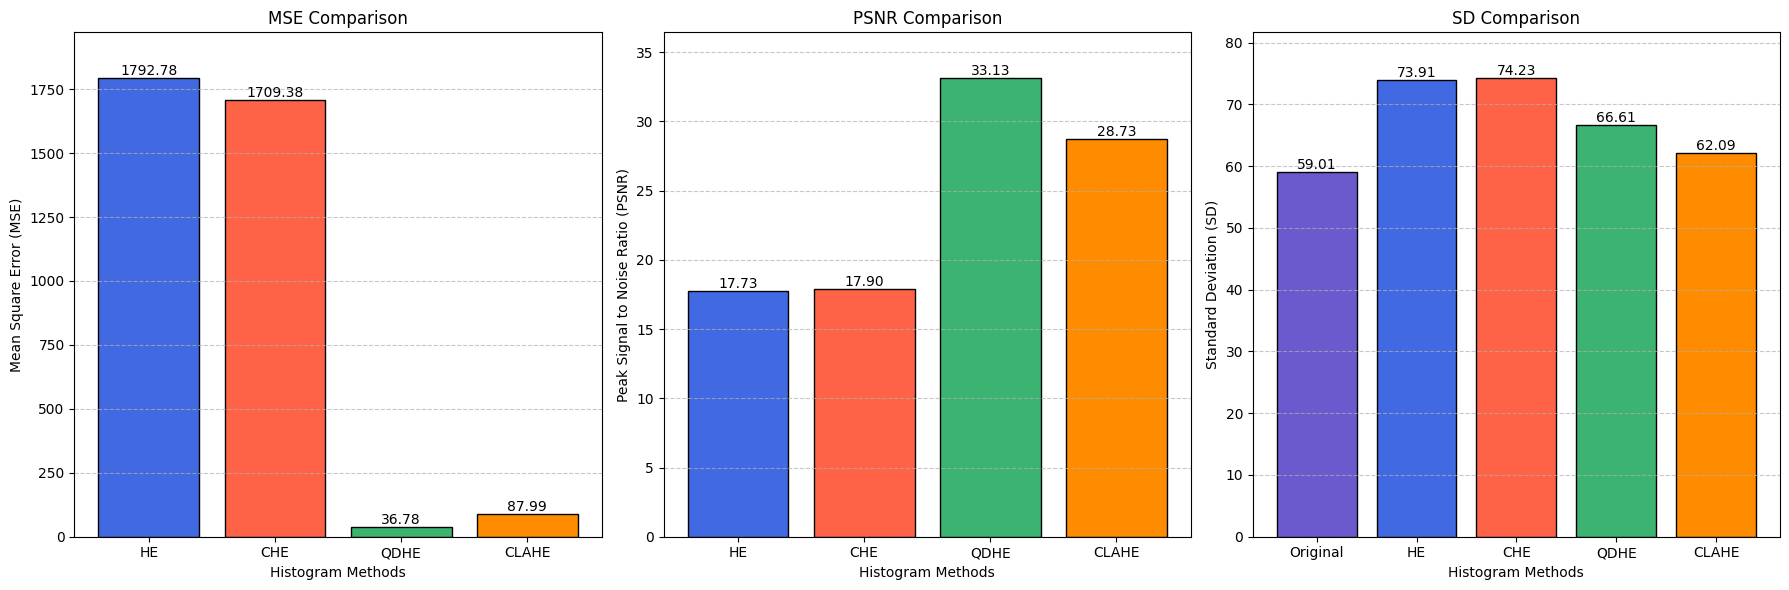

In [18]:
methods = ['Original', 'HE', 'CHE', 'QDHE', 'CLAHE']
mse_values = [mean_mse[method] for method in ['HE', 'CHE', 'QDHE', 'CLAHE']]
psnr_values = [mean_psnr[method] for method in ['HE', 'CHE', 'QDHE', 'CLAHE']]
sd_values = [mean_sd['Original']] + [mean_sd[method] for method in ['HE', 'CHE', 'QDHE', 'CLAHE']]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)


axs[0].bar(['HE', 'CHE', 'QDHE', 'CLAHE'], mse_values, color = ['royalblue', 'tomato', 'mediumseagreen', 'darkorange'], edgecolor='black')
for bar in axs[0].patches:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
axs[0].set_xlabel('Histogram Methods')
axs[0].set_ylabel('Mean Square Error (MSE)')
axs[0].set_title('MSE Comparison')
axs[0].set_ylim(0, max(mse_values) * 1.1 )
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

axs[1].bar(['HE', 'CHE', 'QDHE', 'CLAHE'], psnr_values, color=['royalblue', 'tomato', 'mediumseagreen', 'darkorange'], edgecolor='black')
for bar in axs[1].patches:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
axs[1].set_xlabel('Histogram Methods')
axs[1].set_ylabel('Peak Signal to Noise Ratio (PSNR)')
axs[1].set_title('PSNR Comparison')
axs[1].set_ylim(0, max(psnr_values) * 1.1) 
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

axs[2].bar(methods, sd_values, color=['slateblue','royalblue', 'tomato', 'mediumseagreen', 'darkorange'], edgecolor='black')
for bar in axs[2].patches:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
axs[2].set_xlabel('Histogram Methods')
axs[2].set_ylabel('Standard Deviation (SD)')
axs[2].set_title('SD Comparison')
axs[2].set_ylim(0, max(sd_values) * 1.1) 
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()